# Projet numérique de Science des Données 2025

__Binôme numéro 26 -- ATTALI Eléanor et PAUTREL Esther__

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

Cela permet à ses femmes d'avoir une prédiction du risque obstétrique dans le cas où elle ne pourrait pas consulter un médecin expérimenté, faute de moyens. Néanmoins, cela peut mener à plusieurs dérives, liées à la fiabilité de la prédiction avec les cas de faux négatifs qui entraînerait l'absence de suivi médical, pourtant nécessaire à la femme enceinte, ainsi que ceux des faux positifs, qui peuvent créer un stress, des angoisses psychologiques et conduire paradoxalement à des complications au niveau de la grossesse. 

## Librairies usuelles

In [31]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [32]:
df_train = pd.read_csv('data/donnees_entrainement.csv')
df_train.head()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,21.0,85.0,55.0,7.0,36.2,84.0,1
1,36.0,145.0,100.0,6.9,39.5,73.0,2
2,15.5,120.0,75.0,7.4,39.0,74.0,0
3,49.0,135.0,100.0,15.9,37.8,72.0,1
4,56.5,120.0,90.0,12.0,36.9,74.0,1


Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [33]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')

print(X_train[:5])
print(y_train[:5])

[[ 21.   85.   55.    7.   36.2  84. ]
 [ 36.  145.  100.    6.9  39.5  73. ]
 [ 15.5 120.   75.    7.4  39.   74. ]
 [ 49.  135.  100.   15.9  37.8  72. ]
 [ 56.5 120.   90.   12.   36.9  74. ]]
[1 2 0 1 1]


# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

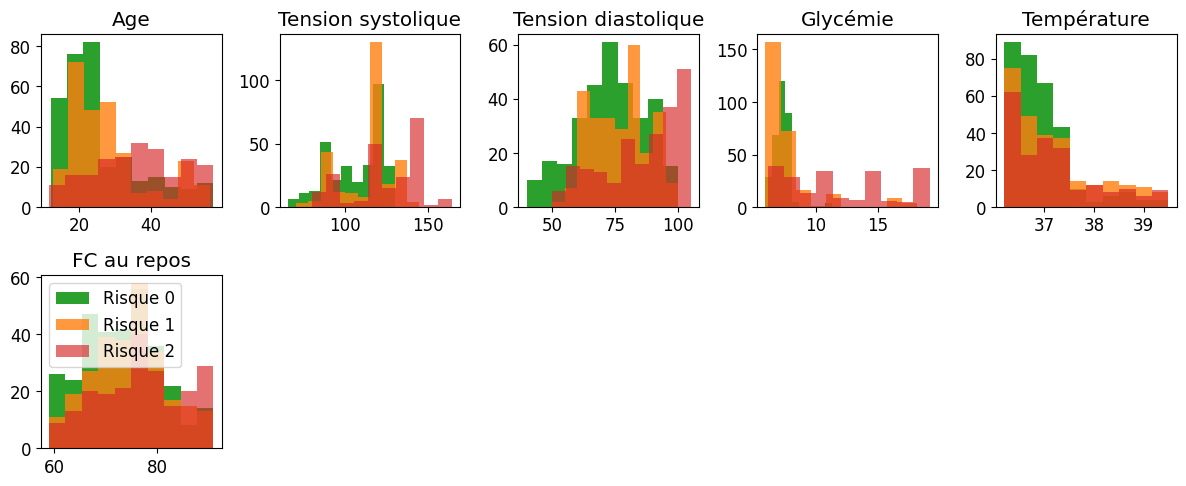

In [34]:
fig = plt.figure(figsize=(12, 5))

# Histogrammes pour les variables continues
for (feat_idx, feat_name) in enumerate(df_train.columns[:-1]):
    # créer une sous-figure (subplot) à la position (feat_idx+1) d'une grille 2x5
    ax = fig.add_subplot(2, 5, (feat_idx+1))

    # afficher l'histogramme de la variable feat_name pour Competition=OlympicG
    h = ax.hist(df_train[df_train['Risque']==0][feat_name], bins=10,  
                color='tab:green', edgecolor='none', alpha=1, label='Risque 0')
    
    # afficher l'histogramme de la variable feat_name pour Competition=Decastar
    h = ax.hist(df_train[df_train['Risque']==1][feat_name], bins=10,  
                color='tab:orange', edgecolor='none', alpha=0.8, label='Risque 1')
    
    # afficher l'histogramme de la variable feat_name pour Competition=OlympicG
    h = ax.hist(df_train[df_train['Risque']==2][feat_name], bins=10,  
                color='tab:red', edgecolor='none', alpha=0.65, label='Risque 2')

    # utiliser le nom de la variable comme titre pour chaque histogramme
    ax.set_title(feat_name)

# Légende
plt.legend()

# espacement entre les subplots
fig.tight_layout(pad=1.0)

### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

Les valeurs prises par les variables d'âge, de tension diastolique, de glycémie et de fréquence cardiaque au repos semblent être corrélées directement au degré de risque obstétrique, ce qui est plutôt logique au vue de la population étudiée (femmes enceintes et diabétiques). Les autres variables manifestent moins fortement le problème, ce qui paraît aussi cohérent avec le degré de risque, à première vue, le diabète et la grossesse n'influençant pas directement la température. 

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

Au vu des résultats obtenus, toutes les variables ne semblent pas corrélées à parts égales au degré de risque, ce qui peut engendrer des difficultés de prédiction, en surchargeant les algorithmes avec des données non significatives.  

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

Text(0.5, 1.0, 'Proportion cumulative de variance expliquée')

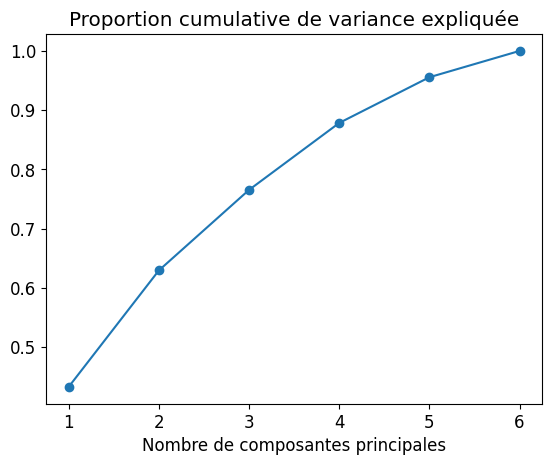

In [35]:
from sklearn import preprocessing
from sklearn import decomposition

#On centre et réduit nos données
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)

# Instanciation d'un objet PCA pour 6 composantes principales
pca = decomposition.PCA(n_components=6)

# On passe maintenant les données standardisées à cet objet
pca.fit(X_train_scaled)

np.cumsum(pca.explained_variance_ratio_)

plt.plot(np.arange(1, 7), np.cumsum(pca.explained_variance_ratio_), marker='o')

plt.xlabel("Nombre de composantes principales")
plt.title("Proportion cumulative de variance expliquée")


Text(0, 0.5, 'PC 2')

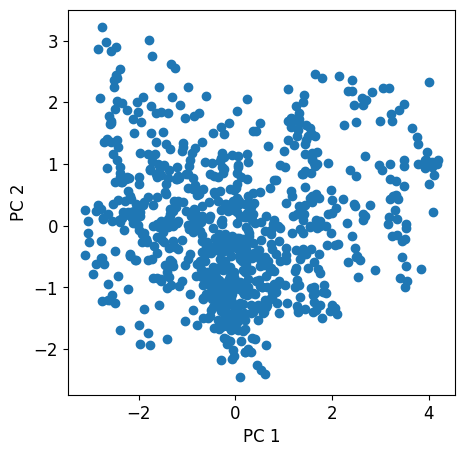

In [36]:
#On projette sur les 2 premières composantes principales
pca = decomposition.PCA(n_components=2)
pca.fit(X_train_scaled)
X_train_projected = pca.transform(X_train_scaled)

fig = plt.figure(figsize=(5, 5))

plt.scatter(X_train_projected[:, 0], X_train_projected[:, 1])

plt.xlabel("PC 1")
plt.ylabel("PC 2")

### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

En ne gardant que les 2 premières composantes principales, on a moins de 65% de la variance expliquée, donc c'est satisfaisant mais le prédicteur de risque ne sera pas assez précis, il sera moins clivant. Il serait mieux de garder au moins les 4 premières composantes, qui expliquent 90% de la variance.  

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

Text(0.5, 1.0, 'Corrélation entre les 6 variables')

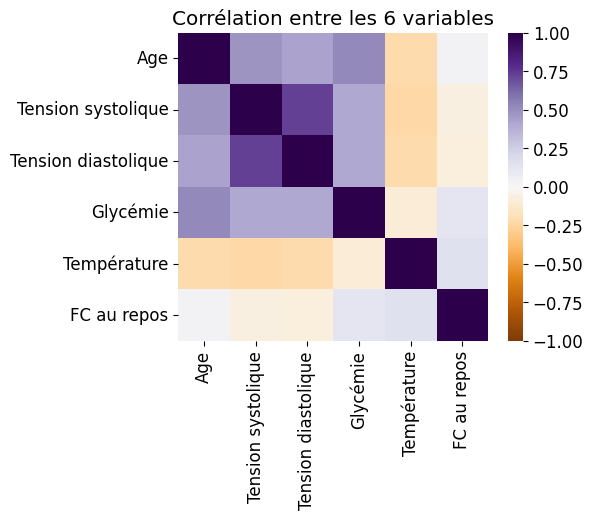

In [37]:
import seaborn as sns
# sns.set_style('whitegrid')

# Calcul de la matrice de corrélation deux à deux
corr_matrix = df_train.drop(columns=['Risque']).corr()

# Initialisation figure
plt.figure(figsize=(5, 4))

# Affichage heatmap
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )
# Titre
plt.title("Corrélation entre les 6 variables")

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

On observe que les tensions systolique et diastolique sont fortement corrélées, ce qui implique qu'elles fournissent à peu près la même information, donc qu'on pourrait n'en "garder" qu'une des deux et ainsi réduire la dimension de 1. 
De manière générale, on ne garde que les variables les moins corrélées. 

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [38]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

X_train = np.array(df_train_risk_vs_norisk.drop('Risque', axis=1))
y_train = y_train_risk_vs_norisk 

In [39]:
df_train_risk_vs_norisk.head()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,21.0,85.0,55.0,7.0,36.2,84.0,1
1,36.0,145.0,100.0,6.9,39.5,73.0,1
2,15.5,120.0,75.0,7.4,39.0,74.0,0
3,49.0,135.0,100.0,15.9,37.8,72.0,1
4,56.5,120.0,90.0,12.0,36.9,74.0,1


## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

In [40]:
risk = (df_train_risk_vs_norisk['Risque']==1).sum()
no_risk = (df_train_risk_vs_norisk['Risque']==0).sum()
accuracy = max(risk, no_risk)/(risk+no_risk)
print(accuracy)

0.605


On obtient une accuracy d'environ 60% pour ce modèle. Il y a un gros pourcentage d'erreur.

### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

Dans le cadre de l'exemple précédent, on obtient BA = 50%, comparé à 60% d'accuracy. Cela pénalise plus le modèle qui prédit que toutes les observations appartiennent à la classe majoritaire, modèle qui est loin d'être optimal.  

Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

Il va attribuer pour chaque donnée l'étiquette de son plus proche voisin qui est lui-même. La phase d'entraînement consiste donc à mémoriser le dataset.

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

On s'attend donc à une précision équilibrée de 100%, car l'étiquette prédite pour chaque donnée est sa propre étiquette, comme elle est son plus proche voisin. 

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [41]:
from sklearn import neighbors
from sklearn.metrics import balanced_accuracy_score


Kneigh = neighbors.KNeighborsClassifier(n_neighbors=1) 
Kneigh.fit(X_train_scaled, y_train_risk_vs_norisk)
y_train_pred = Kneigh.predict(X_train_scaled)
balanced_accuracy_score(y_train_risk_vs_norisk, y_train_pred)



1.0

On obtient bien une précision équilibrée de 1. 

### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

Il vaut mieux standardiser nos données, pour qu'il n'y ait pas une feature qui prenne le pas sur les autres. En effet, pour sélectionner les plus proches voisins, on utilise la distance, qui prend en compte les ordres de grandeurs des différentes variables. 

#Dans un premier temps, il faut trouver la valeur de K (nombre de voisins) optimales. Pour chacune des données du jeu d'entraînement, on regarde, à K fixé, les étiquettes de ses K plus proches voisins et on s'assure que l'étiquette majoritaire correspond à celle de l'observation étudiée, pour la plupart des observations.  
#L'exemple précédent, où on associait à la classe majoritaire, correspond au cas où on prend pour K le nombre total de données - 1, toutes les autres données sont donc des voisins. On obtenait dans ce cas, une précision équilibrée de 50%. Donc on attend une précision équilibrée supérieure à 50%. Dans le cas où la métrique est bien choisie, on peut espérer trouver un K, permettant une précision équilibrée proche de 90%.



## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [i for i in range (1, 100)]} #pour trouver le nombre optimal de voisins

Kneigh_cv = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, scoring='balanced_accuracy', cv=10, n_jobs=-1)
Kneigh_cv.fit(X_train_scaled, y_train_risk_vs_norisk)
Kneigh_cv.best_params_, Kneigh_cv.best_score_ 


({'n_neighbors': 8}, np.float64(0.7416049484309852))

In [43]:
Kneigh_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

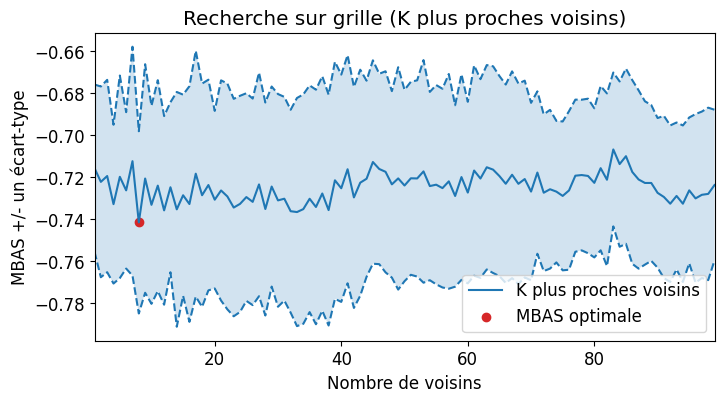

In [44]:
# Définir la grille de valeurs de l'hyperparamètre n_neighbors
nb_voisins = np.array([i for i in range(1, 100)])

# initialize plot frame
plt.figure(figsize=(8, 4))

mbas = -Kneigh_cv.cv_results_['mean_test_score'] #mean balanced accuracy score
std_error = Kneigh_cv.cv_results_['std_test_score']

# afficher les RMSE sans échelle logarithmique pour les abscisses :
plt.plot(nb_voisins, mbas, label="K plus proches voisins", color='tab:blue') #pourquoi afficher rmse et pas balance accuracy?
plt.plot(nb_voisins, mbas + std_error, color='tab:blue', linestyle='dashed')
plt.plot(nb_voisins, mbas - std_error, color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(nb_voisins, (mbas + std_error), (mbas - std_error), 
                 alpha=0.2 # contrôle la transparence
                )

# afficher le meilleur score
plt.scatter(Kneigh_cv.best_params_['n_neighbors'], -Kneigh_cv.best_score_, 
           color='tab:red', label='MBAS optimale')

# Mise en forme
plt.xlabel("Nombre de voisins")
plt.ylabel("MBAS +/- un écart-type")
plt.xlim([nb_voisins[0], nb_voisins[-1]])
plt.title("Recherche sur grille (K plus proches voisins)")
plt.legend(loc='best')

## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [68]:
from sklearn import linear_model

param_grid = {'C' : [1.0, 1.5, 1.75, 2.0, 2.5, 5.0, 10] }
#check hyperparametre à faire varier = coeff de régularisation d'une regression logistique -> choix du type de regularisation (l1 ou l2...)
Logi_cv = GridSearchCV(linear_model.LogisticRegression(), param_grid, scoring='balanced_accuracy', cv=10, n_jobs=-1)
Logi_cv.fit(X_train_scaled, y_train)
Logi_cv.best_params_, Logi_cv.best_score_ 

#la valeur de C optimale est 2.5 pour une precision de 66%

({'C': 2.5}, np.float64(0.6612467769365811))

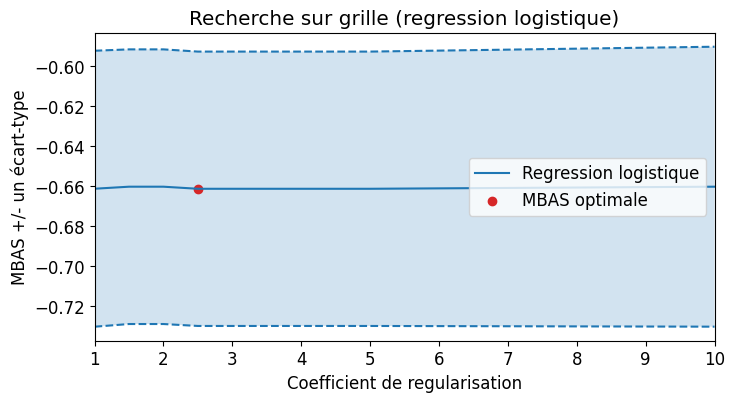

In [69]:
# Définir la grille de valeurs de l'hyperparamètre coefficient de régularisation
param_grid = [1.0, 1.5, 1.75, 2.0, 2.5, 5.0, 10]

# initialize plot frame
plt.figure(figsize=(8, 4))

mbas = -Logi_cv.cv_results_['mean_test_score'] #mean balanced accuracy score
std_error = Logi_cv.cv_results_['std_test_score']

# afficher les RMSE sans échelle logarithmique pour les abscisses :
plt.plot(param_grid, mbas, label="Regression logistique", color='tab:blue') #pourquoi afficher rmse et pas balance accuracy?
plt.plot(param_grid, mbas + std_error, color='tab:blue', linestyle='dashed')
plt.plot(param_grid, mbas - std_error, color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(param_grid, (mbas + std_error), (mbas - std_error), 
                 alpha=0.2 # contrôle la transparence
                )

# afficher le meilleur score
plt.scatter(Logi_cv.best_params_['C'], -Logi_cv.best_score_, 
           color='tab:red', label='MBAS optimale')

# Mise en forme
plt.xlabel("Coefficient de regularisation")
plt.ylabel("MBAS +/- un écart-type")
plt.xlim([param_grid[0], param_grid[-1]])
plt.title("Recherche sur grille (regression logistique)")
plt.legend(loc='best')

## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

In [46]:
#version permettant de tester les differents paramètres
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param = {'n_estimators': [5*i for i in range(1,22)], 'max_depth':[None, 5], 'min_samples_leaf': [1, 2]} 
#nb d'arbres dans le modele, la valeur inferieure correspond à la valeur utilisée par
#defaut dans l'ancienne version python et la valeur superieure quasiment à celle actuellement utilisee (100), il s'agit a priori de valeurs standards raisonnables en complexité
#les autres valeurs sont des valeurs usuelles pour ces paramètres

# initialise modele arbre decision
tree_model = RandomForestClassifier()
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=tree_model, 
                           param_grid=param, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='balanced_accuracy')

grid_search.fit(X_train_scaled, y_train_risk_vs_norisk)
grid_search.best_params_ , grid_search.best_score_ 


#quand le nombre d'arbres est le seul paramètre, on observe une grande variabilite du nb d'arbres trouvé, si on va de 10 à 140 ou de 10 à 130 la valeur trouvee n'est pas du tout la meme cependant la precision reste inchangée ce qui est le plus important
#pour 10<= nb <= 110, valeur optimale nb = 110, precision = 0.80
#pour 10<= nb <= 100,  valeur optimale nb = 60, precision = 0.80
# on a plutot interet à choisir le nb d'arbres le plus petit en terme de temps de calcul dans ce cas :

#en complexifiant les paramètres, le temps de calcul ici est sensiblement pus long ce qui est cohérent, mais la precision reste identique, 
# dans la suite on a tout interet à ne faire varier que le paramètres n_estimators qui joue le plus sur la precision


({'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50},
 np.float64(0.7992661798396334))

In [47]:
#modèle utilisé ensuite
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param = {'n_estimators': [5*i for i in range(1,21)]} 


# initialise modele arbre decision
tree_model = RandomForestClassifier()
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=tree_model, 
                           param_grid=param, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='balanced_accuracy')

grid_search.fit(X_train_scaled, y_train_risk_vs_norisk)
meilleurs_parametres = grid_search.best_params_#on garde les hyperparamètres retenus pour le classifieur binaire final 
grid_search.best_params_ , grid_search.best_score_

({'n_estimators': 55}, np.float64(0.7945538782523318))

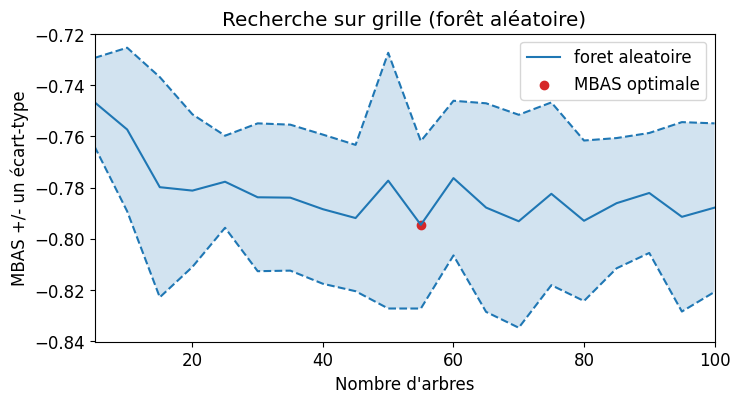

In [48]:
# Définir la grille de valeurs de l'hyperparamètre n_estimators cad le nb d'arbres
nb_trees = np.array([5*i for i in range(1, 21)])


# initialize plot frame
plt.figure(figsize=(8, 4))

mbas = -grid_search.cv_results_['mean_test_score'] #mean balanced accuracy score
std_error = grid_search.cv_results_['std_test_score']

# afficher les RMSE sans échelle logarithmique pour les abscisses :
plt.plot(nb_trees, mbas, label="foret aleatoire", color='tab:blue')
plt.plot(nb_trees, mbas + std_error, color='tab:blue', linestyle='dashed')
plt.plot(nb_trees, mbas - std_error, color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(nb_trees, (mbas + std_error), (mbas - std_error), 
                 alpha=0.2 # contrôle la transparence
                )

# afficher le meilleur score
plt.scatter(grid_search.best_params_['n_estimators'], -grid_search.best_score_, 
           color='tab:red', label='MBAS optimale')

# Mise en forme
plt.xlabel("Nombre d'arbres")
plt.ylabel("MBAS +/- un écart-type")
plt.xlim([nb_trees[0], nb_trees[-1]])
plt.title("Recherche sur grille (forêt aléatoire)")
plt.legend(loc='best')

#en ne faisant varier que le nombre d'arbres entre 10 et 110, on trouve comme paramètre optimal nb_trees = 80. Graphiquement il apparait bien comme le minimum global de rmse
#cependant on voit que la courbe tend à décroitre sur les dernières valeurs, il n'est pas impossible qu'en augmentant legerement le nombre d'arbres dans la simulation
#on trouve une valeur sensiblement differente. peu de stabilite sur l'optimalite du paramètre nb_trees

## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

In [49]:
dic = { Kneigh_cv.best_score_ : "k plus proches voisins", Logi_cv.best_score_ : "regression logistique", grid_search.best_score_ : "foret aleatoire, algo non linéaire"}
print(dic[max(dic)])

#la meilleure performance est obtenue dans le cas de l'algorithme non linéaire

foret aleatoire, algo non linéaire


### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

In [70]:
#on aimerait conserver 95% de la variance expliquee et reduire au plus la dimension. Choisir d'eliminer une composante principale permet d'atteindre raisonnablement cet objectif
pca = decomposition.PCA(n_components=5)
pca.fit(X_train_scaled)
X_train_projected = pca.transform(X_train_scaled)

### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param = {'n_estimators': [5*i for i in range(1,21)]} #nb d'arbres dans le modele, la valeur inferieure correspond à la valeur utilisée par
#defaut dans l'ancienne version python et la valeur superieure quasiment à celle actuellement utilisee (100), il s'agit a priori de valeurs standards raisonnables en complexité

# initialise modele arbre decision
tree_model = RandomForestClassifier()
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=tree_model, 
                           param_grid=param, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='balanced_accuracy')

grid_search.fit(X_train_projected, y_train_risk_vs_norisk)
grid_search.best_params_ , grid_search.best_score_




({'n_estimators': 10}, np.float64(0.7206638132056946))

### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

Au lieu d'utiliser 35 arbres dans le modèle pour une précision de 80%, on en utiliserait 70 pour une précision de 71%. Le modèle avec reduction de dimension est plus complexe et moins précis. Il n'y a aucun intéret à l'utiliser. Cela parait cohérent car dans le modèle des forets aléatoires, les variables sont déjà réduites de façon aléatoire à chaque noeud. On comprime déjà beaucoup les données utilisées et le temps de calcul de cette façon. Procéder à une réduction de dimension dans ce cas représente une vraie perte d'information dans le cas où les variables sont déjà peu corrélées.


## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

In [71]:
final_binary_classifier = RandomForestClassifier(n_estimators= meilleurs_parametres['n_estimators'])
final_binary_classifier.fit(X_train_scaled, y_train_risk_vs_norisk)


,n_estimators,55
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

In [72]:
df_test = pd.read_csv("data/donnees_reservees.csv")
df_test['Risque'] = np.where(df_test['Risque']==2, 1, df_test['Risque'])
df_test.head()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,20.5,120.0,70.0,6.6,36.7,71.0,0
1,50.5,130.0,100.0,15.9,36.3,72.0,1
2,23.0,120.0,90.0,7.5,37.0,64.0,0
3,17.5,120.0,75.0,7.2,36.2,65.0,0
4,23.5,125.0,85.0,8.1,36.7,64.0,0


### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

In [74]:
X_test = np.array(df_test.drop('Risque', axis=1))
y_test = np.array(df_test['Risque'], dtype='int')

X_test_scaled = std_scale.transform(X_test)

prediction = final_binary_classifier.predict(X_test_scaled)

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

In [75]:
from sklearn.metrics import balanced_accuracy_score
score = balanced_accuracy_score(prediction, y_test)
print(score)

#on obtient ici un precision de 85% sur les données test pour une precision de 80% sur les données d'entrainement
#notre modèle apprend bien

0.8712518740629684


### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

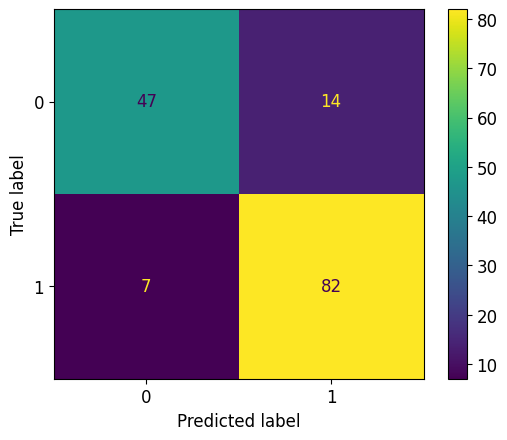

In [56]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, prediction)).plot()


### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

La matrice de précision nous indique que pour détecter les grossesses à risque le modèle construit est plutôt performant. En ce qui concerne la prédicition des grossesses n'étant pas à risque, il reste performant, mais moins que pour prédire la présence du risque. La proportion de grossesses à risque prédites comme n'étant pas à risque est assez faible, ce qui est encourageant, car c'est le scénario le pire, que l'on veut donc éviter à tout prix. En effet, il peut impacter le bien-être et le mental des femmes concernées, donc le fait que la prédiction d'un tel scénario n'est pas nulle est tout de même embêtant. 

Il serait possible d'utiliser un tel classifieur pour décider quelles femmes référer pour un suivi médical attentif de leur grossesse, surtout dans le contexte présentée au début du projet, à savoir une région défavorisée du monde. Il faudra tout de même, en cas d'utilisation d'un tel classifieur, bien informer les femmes concernées que la prédiction n'est pas fiable à 100% et leur conseillez en cas de symptômes quelconques de ne pas attendre pour consulter un médecin. 

Enfin, un soucis que présente ce classifieur est son côté binaire. En effet, son utilisation mènerait donc des femmes ayant des grossesses à risque moyen et celles à risque élevée à consulter "au même titre" un médecin compétent, ce qui n'est peut-être pas aussi nécessaire ou urgent dans le cas de grossesses dont le risque est seulement modéré. 

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

Les algorithmes non linéaires comme les forêts aléatoires et les perceptrons multicouches se prêtent directement à l'entraînement d'un classifieur multiclasse, au contraire de la régression logistique et de l'algorithme des K plus proches voisins. 

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param = {'n_estimators': [5*i for i in range(1,22)], 'min_samples_leaf': [1, 2, 3, 4, 5]} 

# initialise modele arbre decision
tree_model = RandomForestClassifier()
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=tree_model, 
                           param_grid=param, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='balanced_accuracy')

grid_search.fit(X_train_scaled, y_train)
grid_search.best_params_ , grid_search.best_score_ 
final_best_param = grid_search.best_params_


### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.

In [58]:
final_multiclass_classifier = RandomForestClassifier(n_estimators=final_best_param['n_estimators'], min_samples_leaf=final_best_param['min_samples_leaf'])
final_multiclass_classifier.fit(X_train_scaled, y_train)

df_test = pd.read_csv("data/donnees_reservees.csv")
X_test = np.array(df_test.drop('Risque', axis=1))
y_test = np.array(df_test['Risque'], dtype='int') #on garde les 3 classes pour les étiquettes 

X_test_scaled = std_scale.transform(X_test)

final_prediction = final_multiclass_classifier.predict(X_test_scaled)

from sklearn.metrics import balanced_accuracy_score
score = balanced_accuracy_score(final_prediction, y_test)
print(score)

0.613031914893617


/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Commentaire : on obtient une précision équilibrée d'environ 80% pour la prédiction du risque des grossesses répartie en 3 classes, ce qui est satisfaisant. 